In [1]:
from src import data_setup, engine, utils, models
from importlib import reload

[reload(m) for m in (data_setup, engine, utils, models)]
device = engine.initialize()

[CONNECTED] NVIDIA GeForce RTX 3070


In [2]:
import torch
from torchvision.datasets import OxfordIIITPet as SET
from torchvision.transforms import ToTensor, Compose, Resize, TrivialAugmentWide
from matplotlib import pyplot as plt
from pathlib import Path

class ToDevice:
    def __init__(self):
        self.device = device
    def __call__(self, x):
        return x.to(self.device)

IMG_SIZE = 64
transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)),
    TrivialAugmentWide(num_magnitude_bins=8),
    ToTensor(), lambda x: x*2 - 1,
    ToDevice()])

data_dir = Path('data')
torch.set_default_device(device)
args_list = [{'root': data_dir, 'split': s, 'transform': transform, 'download': True} for s in ('trainval', 'test')]
data = [SET(**args) for args in args_list]
data

[Dataset OxfordIIITPet
     Number of datapoints: 3680
     Root location: data
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                <function <lambda> at 0x000002143ADF13A0>
            ),
 Dataset OxfordIIITPet
     Number of datapoints: 3669
     Root location: data
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=8, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                <function <lambda> at 0x000002143ADF13A0>
            )]

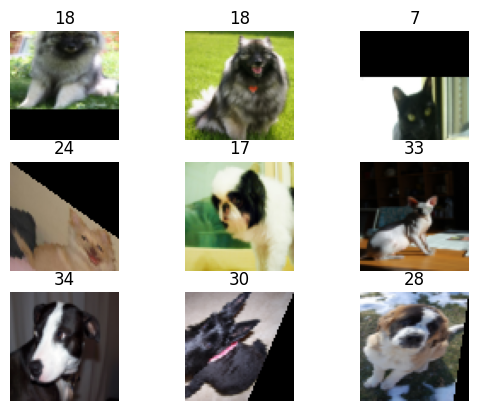

In [3]:
from torch.utils.data import DataLoader
loader = DataLoader(data[0], shuffle=True, generator=torch.Generator(device='cuda'))
utils.visualize(loader, 9, transform=lambda x: (x+1)/2)

### Diffusion Model Steps:
1. The forward process = Noise Schedular
2. The backward process = U-Net
3. The loss

### Noise Schedular

In [4]:
from torch.nn import functional as F
def linear_beta_schedule(timesteps, start=1e-4, end=2e-2):
    return torch.linspace(start, end, timesteps)

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
# Next step at t
#   = q( x_t │ x_(t-1) )
#   = N(x_t, √(1-β)*x_(t-1), β_t*I)
#   = √(1-β_t)*x_(t-1) + √(β_t)*ϵ
#   = √(α_t)*x_(t-1) + √(1-α_t)*ϵ

# Need sqrt_alpha_t & sqrt_one_minus_alpha_t
# α_t = ∏_(s=1)^(t) (a_s)
# sqrt_alpha_t = sqrt_alphas_cumprod = √(α_t)
# sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod = √(1-α_t)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas = torch.sqrt(alphas_cumprod)
sqrt_1_alphas = torch.sqrt(1. - alphas_cumprod)

# dunno yet why do I need this
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [7]:
def get_index_from_list(
        vals: torch.Tensor, t: torch.Tensor, x_shape: torch.Size
):
    """
    :param vals: torch vector
    :param t: Diffusion timestep. Shape -> (1)
    :param x_shape: batch shape
    :return:
        A specific index t of a passed list of values vals
        while considering the batch dimension.
    """

    batch_size = t.shape[0]
    out = vals.gather(-1, t)
    return out.reshape(batch_size, *( (1,) * (len(x_shape)-1) )).to(t.device)

def map_x(x, a0, a1):
    x_min, x_max = x.min(), x.max()
    return  (x - x_min) * ( (a1 - a0) / (x_max - x_min) ) + a0

def forward_diffusion_sample(x_0: torch.Tensor, t: torch.Tensor):
    """
    :param x_0: Original Image. Shape -> (c, h, w)
    :param t: Diffusion timestep. Shape -> (1)
    :return: The noisy version of x_0 at t
    """

    noise = torch.randn_like(x_0)  # Normal distribution ~ mu=0, var=1
    sqrt_alpha_t = get_index_from_list(sqrt_alphas, t, x_0.shape)
    sqrt_1_alpha_t = get_index_from_list(sqrt_1_alphas, t, x_0.shape)

    # x_t = sqrt(a)*x_0 + sqrt(1-a)*ε
    x_t = sqrt_alpha_t*x_0 + sqrt_1_alpha_t*noise

    # Experimental: BIG MISTAKE
    # x_t = map_x(x_t, -1, 1)
    return x_t, noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


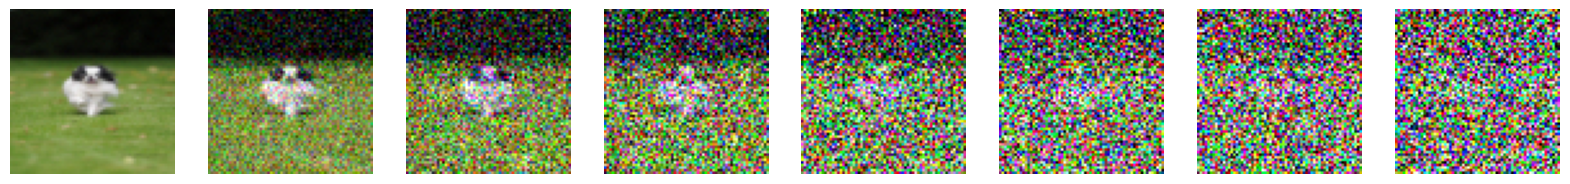

In [8]:
# demo
plt.figure(figsize=(20, 10))
x_0 = next(iter(loader))[0][0]
n = 7
steps = range(0, T, T//n)
for i, step in enumerate(steps):
    t = torch.tensor([step], dtype=torch.int64, device=device)
    x_t, _ = forward_diffusion_sample(x_0, t)

    img = (x_t.detach().cpu().permute(1,2,0)+1)/2

    plt.subplot(1, n+1, i+1)
    plt.imshow(img)
    plt.axis('off')

### U-Net

In [9]:
from torch import nn
import math
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time.unsqueeze(-1) * embeddings.unsqueeze(0)
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [10]:
PE = SinusoidalPositionEmbeddings(32)
e = PE(torch.LongTensor([[4]]))
e, e.shape

(tensor([[[-7.5680e-01,  8.2877e-01,  9.2132e-01,  5.9234e-01,  3.3639e-01,
            1.8460e-01,  1.0031e-01,  5.4347e-02,  2.9421e-02,  1.5924e-02,
            8.6176e-03,  4.6636e-03,  2.5238e-03,  1.3658e-03,  7.3914e-04,
            4.0000e-04, -6.5364e-01, -5.5958e-01,  3.8881e-01,  8.0569e-01,
            9.4172e-01,  9.8281e-01,  9.9496e-01,  9.9852e-01,  9.9957e-01,
            9.9987e-01,  9.9996e-01,  9.9999e-01,  1.0000e+00,  1.0000e+00,
            1.0000e+00,  1.0000e+00]]]),
 torch.Size([1, 1, 32]))

In [11]:
import numpy as np
arr = np.asarray([1,2,3,4,5])
indices = (..., ) + (None, ) * 2
print(arr.shape)
arr = arr[indices]
print(arr.shape)

(5,)
(5, 1, 1)


In [12]:
class TransformBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]  # unsqueeze(-1) x2
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [13]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([TransformBlock(down_channels[i], down_channels[i+1], time_emb_dim)
                                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([TransformBlock(up_channels[i], up_channels[i+1], time_emb_dim, up=True)
                                  for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [14]:
from types import MethodType
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): TransformBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): TransformBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [15]:
def imshow(x):
    x = map_x(x, 0, 1)
    img = x.detach().cpu().squeeze().permute(1,2,0)
    plt.imshow(img)
    plt.axis('off')

In [ ]:
x = torch.randn((1,3,64,64))
imshow(x)

In [ ]:
t = torch.tensor([100], dtype=torch.long)
y = model(x, t)
imshow(y)

In [18]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [19]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_1_alphas_t = get_index_from_list(
        sqrt_1_alphas, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_1_alphas_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            imshow(img)
    plt.show()

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

BATCH_SIZE = 1

for epoch in range(epochs):
    for step, batch in enumerate(loader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()